# Forming Incomplete Point Clouds (Simulation Data)

The simulations record the trajectories (a series of x,y,z coordinates, with associated amplitude of each point) of products resulting from collision/reaction between Mg22 and alpha particles in ATTPC.

This notebook uses simulated ATTPC data of collision/reaction between Mg22 and alpha particles, and creates two preprocessed datasets:
(1) Complete Point Clouds
(2) Incomplete Point Clouds, manually broken with 4 distinct functions.

Data preprocessing pipeline is as following:  
1. Load data from .h5 files into NumPy arrays
2. Data exploration
3. Uniformly sample each event to a fixed number of points
4. Filter out events with too few unique points 
5. Break point clouds
6. Scale all point coordinates and log of charge using min-max normalization
7. Save the final datasets to .npy files.

-Kerem

## User-Desired Settings

The isotope used in this experiment is Mg22.

In [1]:
ISOTOPE = 'line'

In [2]:
sample_size = 256

In [3]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
import h5py
import numpy as np
import tqdm
import math
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits import mplot3d
import cutting_functions as cf

In [5]:
dir_name = './'

## Import Libraries

In [6]:
N_COMPLETE = 2048
N_PARTIAL = 1024 + 512
MIN_N_UNIQUE = 128

RANGES = {
        'MIN_X' : 0,
        'MAX_X' :  1,
        'MIN_Y' : 0,
        'MAX_Y' :  2,
        'MIN_Z' : -2,
        'MAX_Z' : 2,
        'MIN_LNQ' :  0,
        'MAX_LNQ' : 1
    }

RNG = np.random.default_rng()

## 1. Load Data

In [7]:
def generate_line_points(z_start, z_end, total_points, y_value):
    """
    Generate points along a line primarily extending along the z-axis from z_start to z_end.
    The y value is fixed for all points within a line but differs across lines.
    """
    zs = np.linspace(z_start, z_end, total_points)
    points = np.zeros((total_points, 3))
    points[:, 1] = y_value  # Fixed y value for all points in the line
    points[:, 2] = zs  # z-coordinates vary along the line
    return points

def generate_noisy_line_points(z_start, z_end, total_points, y_value):
    """
    Generate noisy points along a line extending along the z-axis from z_start to z_end.
    The y value is fixed for all points within a line but differs across lines. 
    Noise is added to the x and y dimensions, with the noise level in the y dimension 
    increasing based on the fixed y value for the line.
    """
    zs = np.linspace(z_start, z_end, total_points)
    points = np.zeros((total_points, 3))
    
    # Increase noise level for the fixed y value
    noise_level = y_value * 0.1  # Adjust this factor as needed
    
    noise_x = np.random.normal(0, noise_level, total_points)
    # For y, the noise is added around the fixed y value
    noise_y = np.random.normal(y_value, noise_level, total_points)
    
    points[:, 0] = noise_x  # Apply noise to x-coordinate
    points[:, 1] = noise_y  # Apply variable noise to fixed y-coordinate
    points[:, 2] = zs  # Set z-coordinate
    
    return points

def generate_lines_dataset(num_lines, total_points, z_range, y_range, noisy=False):
    """
    Generate a dataset of 3D line point clouds along the z-axis, with each line having a fixed y value.
    An option for adding noise is available, which affects the x and y dimensions.
    """
    z_start, z_end = z_range
    dataset = np.zeros((num_lines, total_points, 4))  # 3 coordinates + 1 charge
    
    for i in range(num_lines):
        # Generate a fixed y value for each line
        y_value = np.random.uniform(*y_range)
        
        if noisy:
            points = generate_noisy_line_points(z_start, z_end, total_points, y_value)
        else:
            points = generate_line_points(z_start, z_end, total_points, y_value)
        
        # Assign points to dataset, with a random charge for each point
        for j in range(points.shape[0]):
            x, y, z = points[j]
            c = np.random.uniform(0, 1)  # Charge
            dataset[i, j] = [x, y, z, c]
    
    return dataset

When running this notebook the second time, simply reload the data (instead of spending 10 min to repeat the step above).

In [8]:
num_lines = 1280
total_points = 256  # Total points per line
z_range = (-2, 2)  # Range for the z-axis
y_range = (0, 2)  # Range for generating fixed y values for each line

data = generate_lines_dataset(num_lines, total_points, z_range, y_range)
data.shape

(1280, 256, 4)

## 2. Data Exploration

In [9]:
def visualize_datasets(d1, title1='Dataset 1'):
    # Load the datasets
    dataset1 = d1
    # dataset2 = d2
    
    fig = plt.figure(figsize=(14, 12))

    for i in range(15):
        ax = fig.add_subplot(5, 4, i + 1, projection='3d', title=f'{title1} #{i+1}')
        ax.scatter(dataset1[i, :, 0], dataset1[i, :, 1], dataset1[i, :, 2], c=dataset1[i, :, 3], cmap='cool', marker='o')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-1, 1])
        ax.set_ylim([0, 2])
        ax.set_zlim([-2, 2])

    # for i in range(10):
    #     ax = fig.add_subplot(5, 4, i + 11, projection='3d', title=f'{title2} #{i+1}')
    #     ax.scatter(dataset2[i, :, 0], dataset2[i, :, 1], dataset2[i, :, 2], c=dataset2[i, :, 3], cmap='cool')
    #     ax.set_xlabel('X')
    #     ax.set_ylabel('Y')
    #     ax.set_zlabel('Z')
    #     ax.set_xlim([-1, 1])
    #     ax.set_ylim([0, 2])
    #     ax.set_zlim([-2, 2])

    plt.tight_layout()
    plt.show()

#visualize_datasets('mix.npy', 'mix_noisy.npy')



(1280, 256, 4)


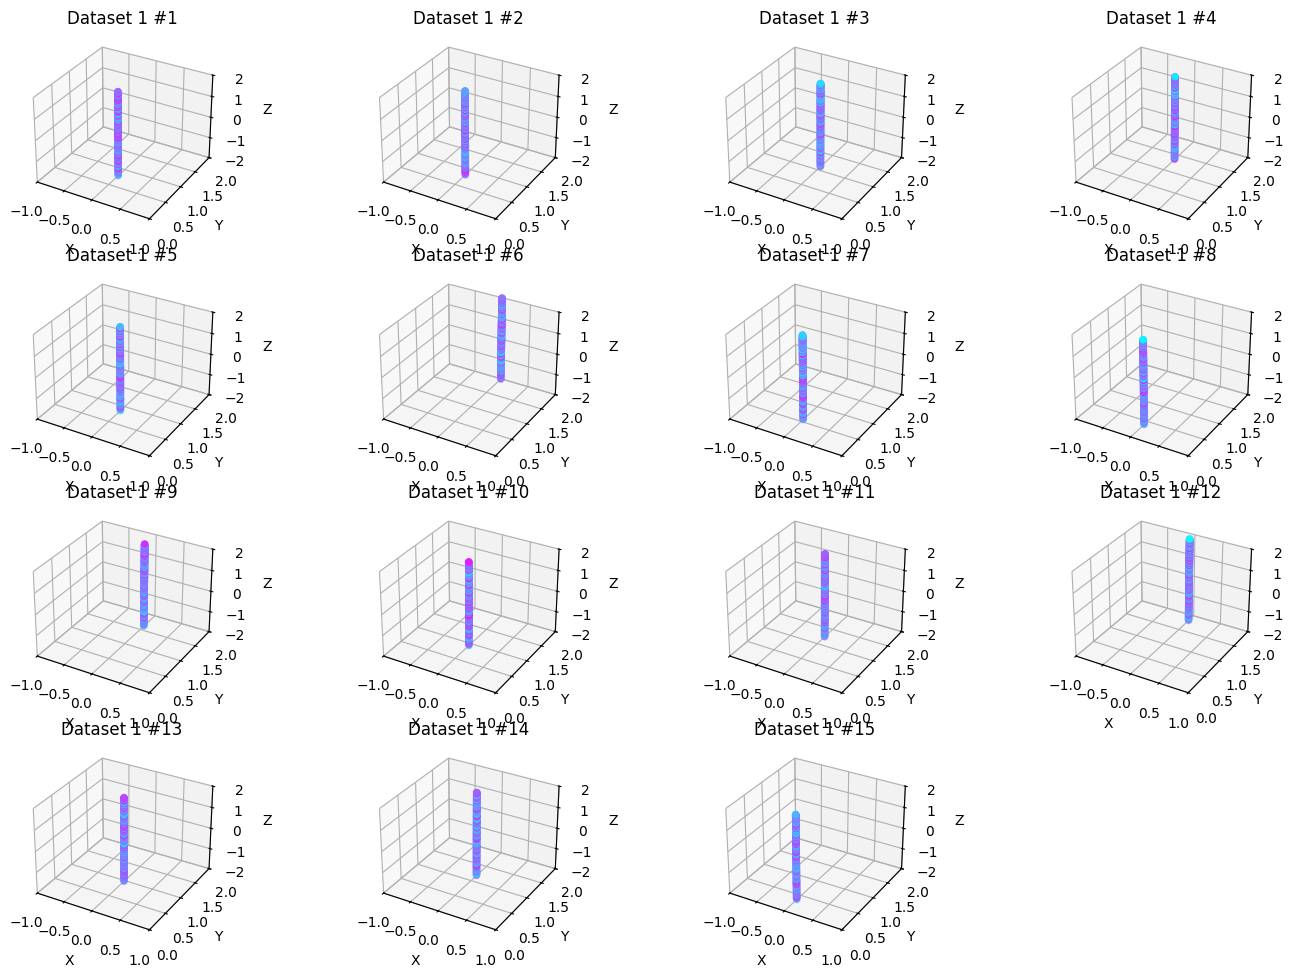

In [10]:
print(data.shape)
#plot_4d_point_clouds(data_xyzq[:5], title="Raw Line Events")
visualize_datasets(data)

## 5. Break the PC

In [11]:
def break_point_cloud(event, method='center', k=64, rng=None):
    """
    General wrapper for point cloud breaking methods.
    
    Parameters:
        event : np.ndarray
            Input 4D point cloud of shape (N, 4)
        method : str
            One of: 'center', 'random_z', 'middle', 'downsample'
        k : int
            Number of points to remove
        rng : np.random.Generator or None
            Optional RNG for consistent results
    
    Returns:
        broken_event : np.ndarray
            Output broken point cloud
    """
    if method == 'center':
        return cf.center_cut(event, k)
    elif method == 'random_z':
        return cf.rand_cut(event, k, rng if rng else np.random.default_rng())
    elif method == 'middle':
        return cf.middle_cut(event, k)
    elif method == 'downsample':
        return cf.down_sample(event, k)
    else:
        raise ValueError(f"Unknown breaking method: {method}")
        


In [12]:
from tqdm import tqdm

rng = np.random.default_rng(seed=58)
broken_clouds_center = []
broken_clouds_random_z = []
broken_clouds_middle = []
broken_clouds_downsample = []

for cloud in tqdm(data):
    broken_center = break_point_cloud(cloud, method='center', k=100, rng=rng)
    #broken_random = break_point_cloud(cloud, method='random_z', k=512, rng=rng)
    # broken_middle = break_point_cloud(cloud, method='middle', k=64, rng=rng)
    # broken_ds = break_point_cloud(cloud, method='downsample', k=64, rng=rng)
    
    broken_clouds_center.append(broken_center)
    #broken_clouds_random_z.append(broken_random)
    # broken_clouds_middle.append(broken_middle)
    # broken_clouds_downsample.append(broken_ds)

broken_clouds_center = np.array(broken_clouds_center)
#broken_clouds_random_z = np.array(broken_clouds_random_z)
# broken_clouds_middle = np.array(broken_clouds_middle)
# broken_clouds_downsample = np.array(broken_clouds_downsample)
#print(broken_clouds.shape)
print(broken_clouds_center.shape)

#data_path = dir_name  + ISOTOPE + '_sim' +'broken.npy'
#np.save(data_path, broken_clouds)

100%|██████████| 1280/1280 [00:00<00:00, 4383.78it/s]

(1280, 156, 4)


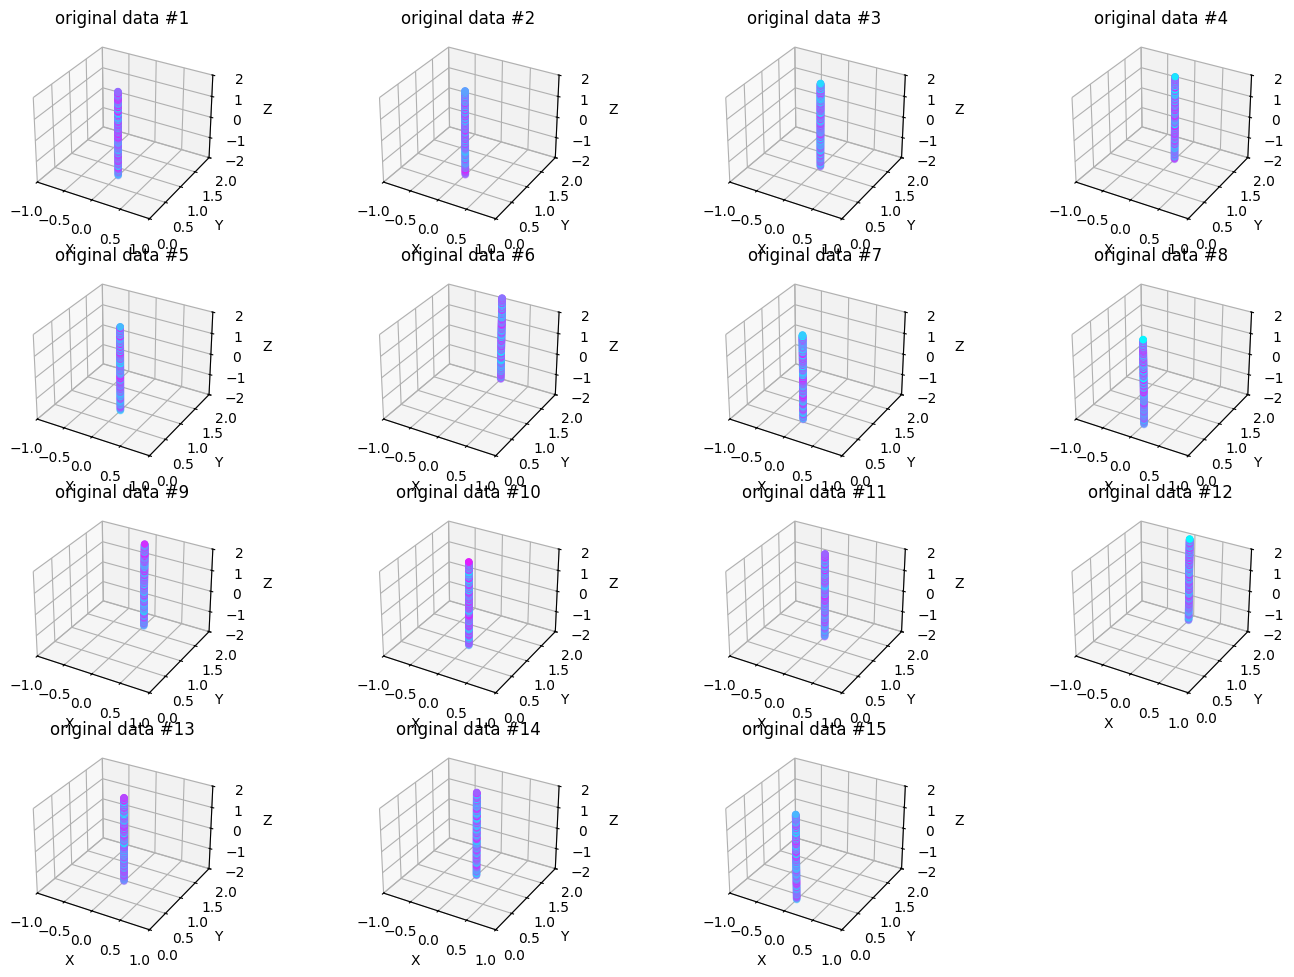

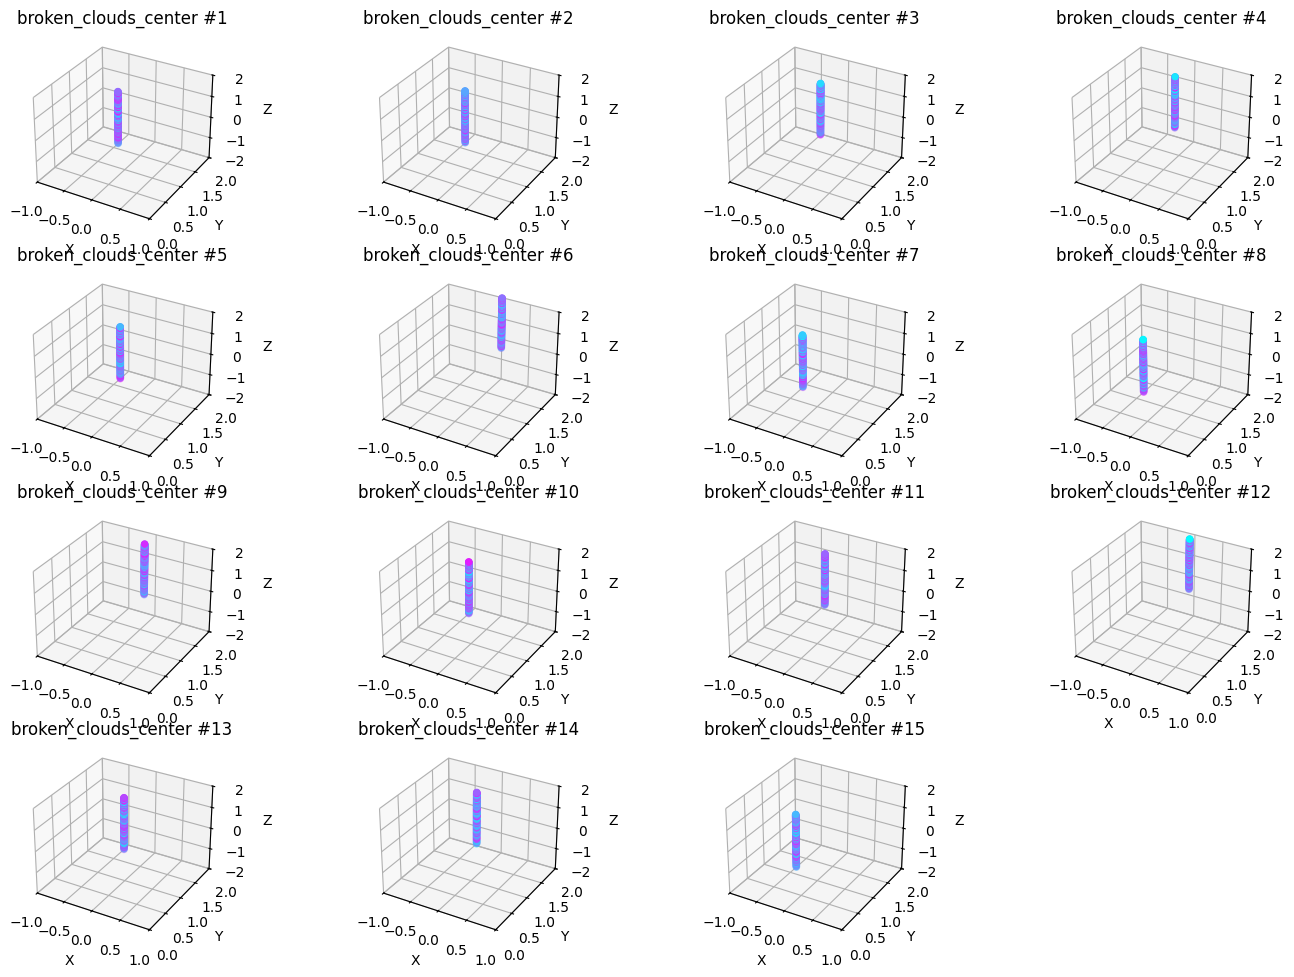

In [13]:
visualize_datasets(data, "original data")
visualize_datasets(broken_clouds_center, "broken_clouds_center")
#visualize_datasets(broken_clouds_middle, "broken_clouds_middle")
# visualize_datasets(broken_clouds_downsample, "broken_clouds_ds")
# plot_4d_point_clouds(broken_clouds_random_z[:2], "random z")
#plot_4d_point_clouds(broken_clouds_middle[:5], "middle")
#plot_4d_point_clouds(broken_clouds_downsample[:5], "downsample")

In [21]:
print(data.shape)
print(broken_clouds_center.shape)
# print(broken_clouds_downsample.shape)
# print(broken_clouds_middle.shape)
# print(broken_clouds_random_z.shape)

(1280, 256, 4)
(1280, 192, 4)


## 6. Scale Data

In [22]:
def scale_data(data, ranges):
    """
    Min/Max scales data based on ranges (logs qs first)

    Parameters:
        data: numpy.ndarray - data to scale
        ranges: dict - contains min and max values of x,y,z, and ln(q)

    Returns:
        scaled: numpy.ndarray - scaled data
    """

    scaled = np.ndarray(data.shape)

    for i, ev in enumerate(data):
        xs, ys, zs, qs = ev[:, 0], ev[:, 1], ev[:, 2], ev[:, 3]

        dxs = (xs - ranges['MIN_X']) / (ranges['MAX_X'] - ranges['MIN_X'])
        dys = (ys - ranges['MIN_Y']) / (ranges['MAX_Y'] - ranges['MIN_Y'])
        dzs = (zs - ranges['MIN_Z']) / (ranges['MAX_Z'] - ranges['MIN_Z'])
        dqs = (np.log(qs) - ranges['MIN_LNQ']) / (ranges['MAX_LNQ'] - ranges['MIN_LNQ'])

        scaled[i, :, 0] = dxs
        scaled[i, :, 1] = dys
        scaled[i, :, 2] = dzs
        scaled[i, :, 3] = dqs

    return scaled

In [23]:
def plot_4d_point_clouds_scaled(arr, title=None):
    fig = plt.figure(figsize=(20, 10))
    for i in range(len(arr)):
        ax = fig.add_subplot(2, 5, i+1, projection='3d')
        cloud = arr[i]
        
        # Extract coordinates and color values
        xs = cloud[:, 0]
        ys = cloud[:, 1]
        zs = cloud[:, 2]
        colors = cloud[:, 3]
        
        # Handle log-scale issues: add epsilon before log if needed
        colors = np.log10(np.clip(colors, 1e-6, None))  # avoid log(0)
        colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors) + 1e-6)  # normalize to [0,1]
        
        # Plot
        sc = ax.scatter(xs, ys, zs, c=colors, cmap='cool', s=5)  # ← increased size to s=5
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_zlim([0, 1])
        ax.set_title(f'Point Cloud {i+1}', fontsize=10)
        fig.colorbar(sc, ax=ax, shrink=0.5)
        
    if title:
        plt.suptitle(title, fontsize=16)
        plt.subplots_adjust(top=0.5)  # leave space for the super title

    plt.tight_layout()
    plt.show()


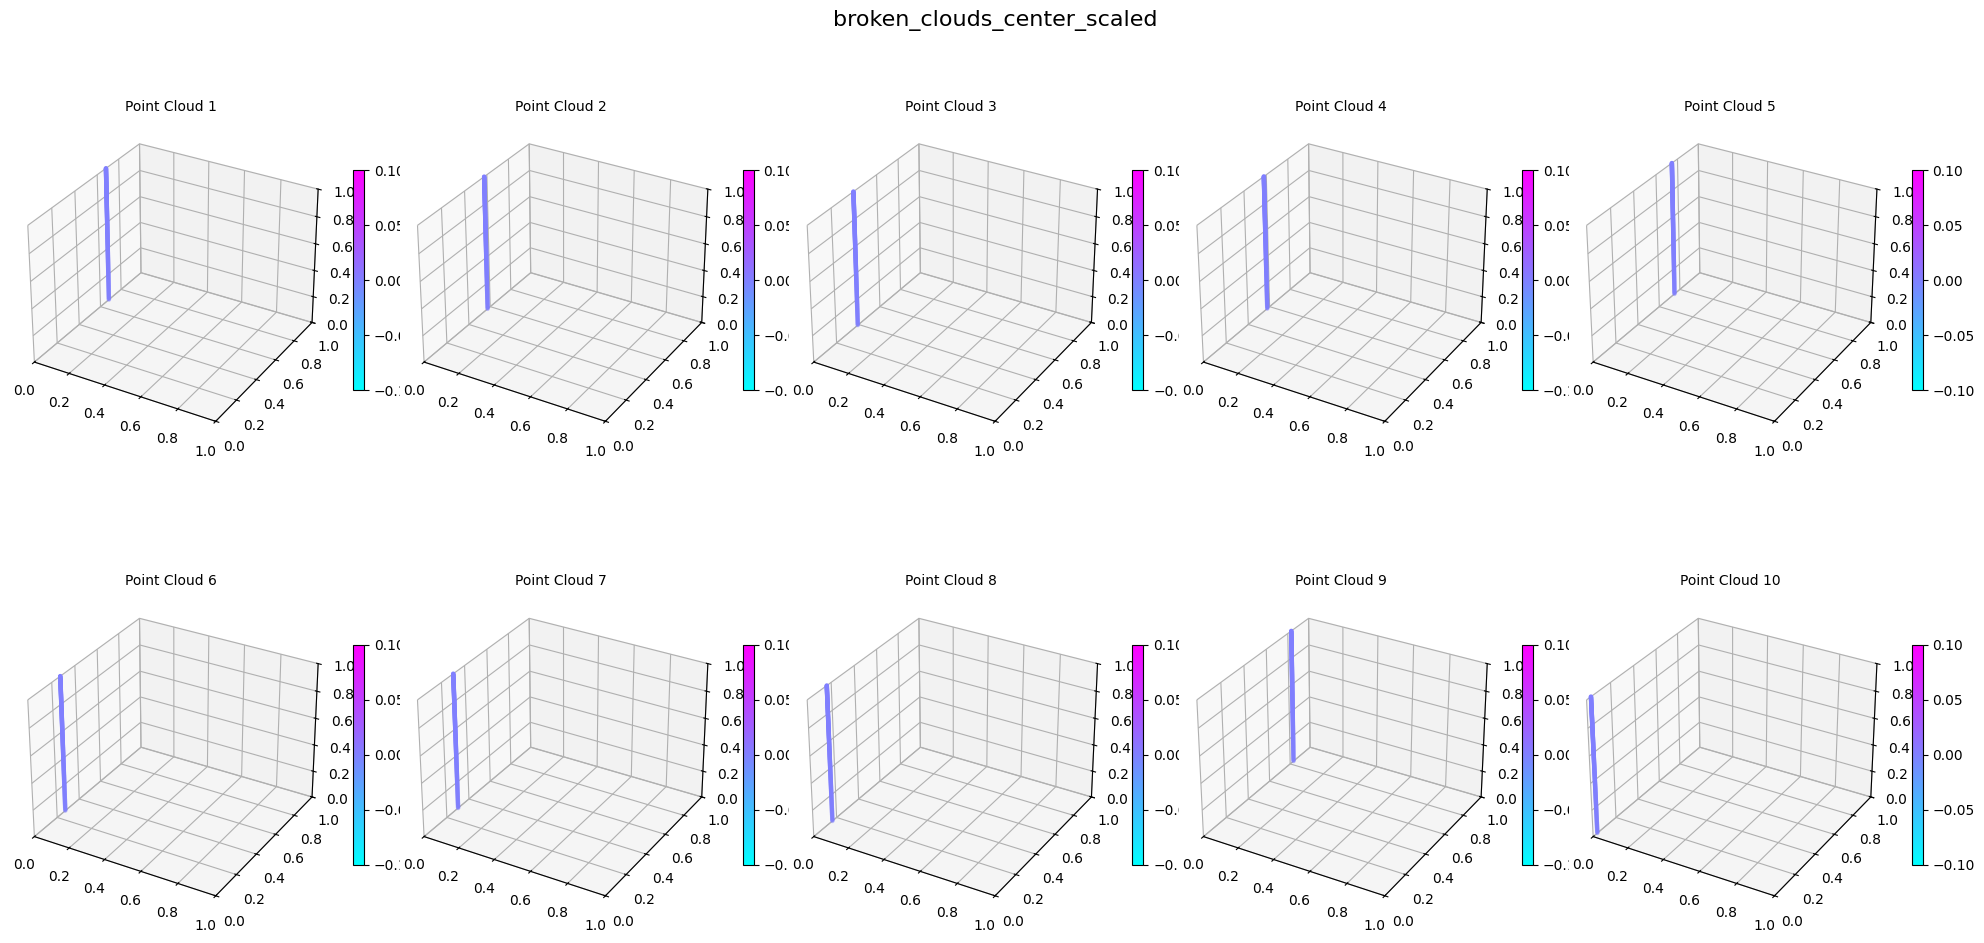

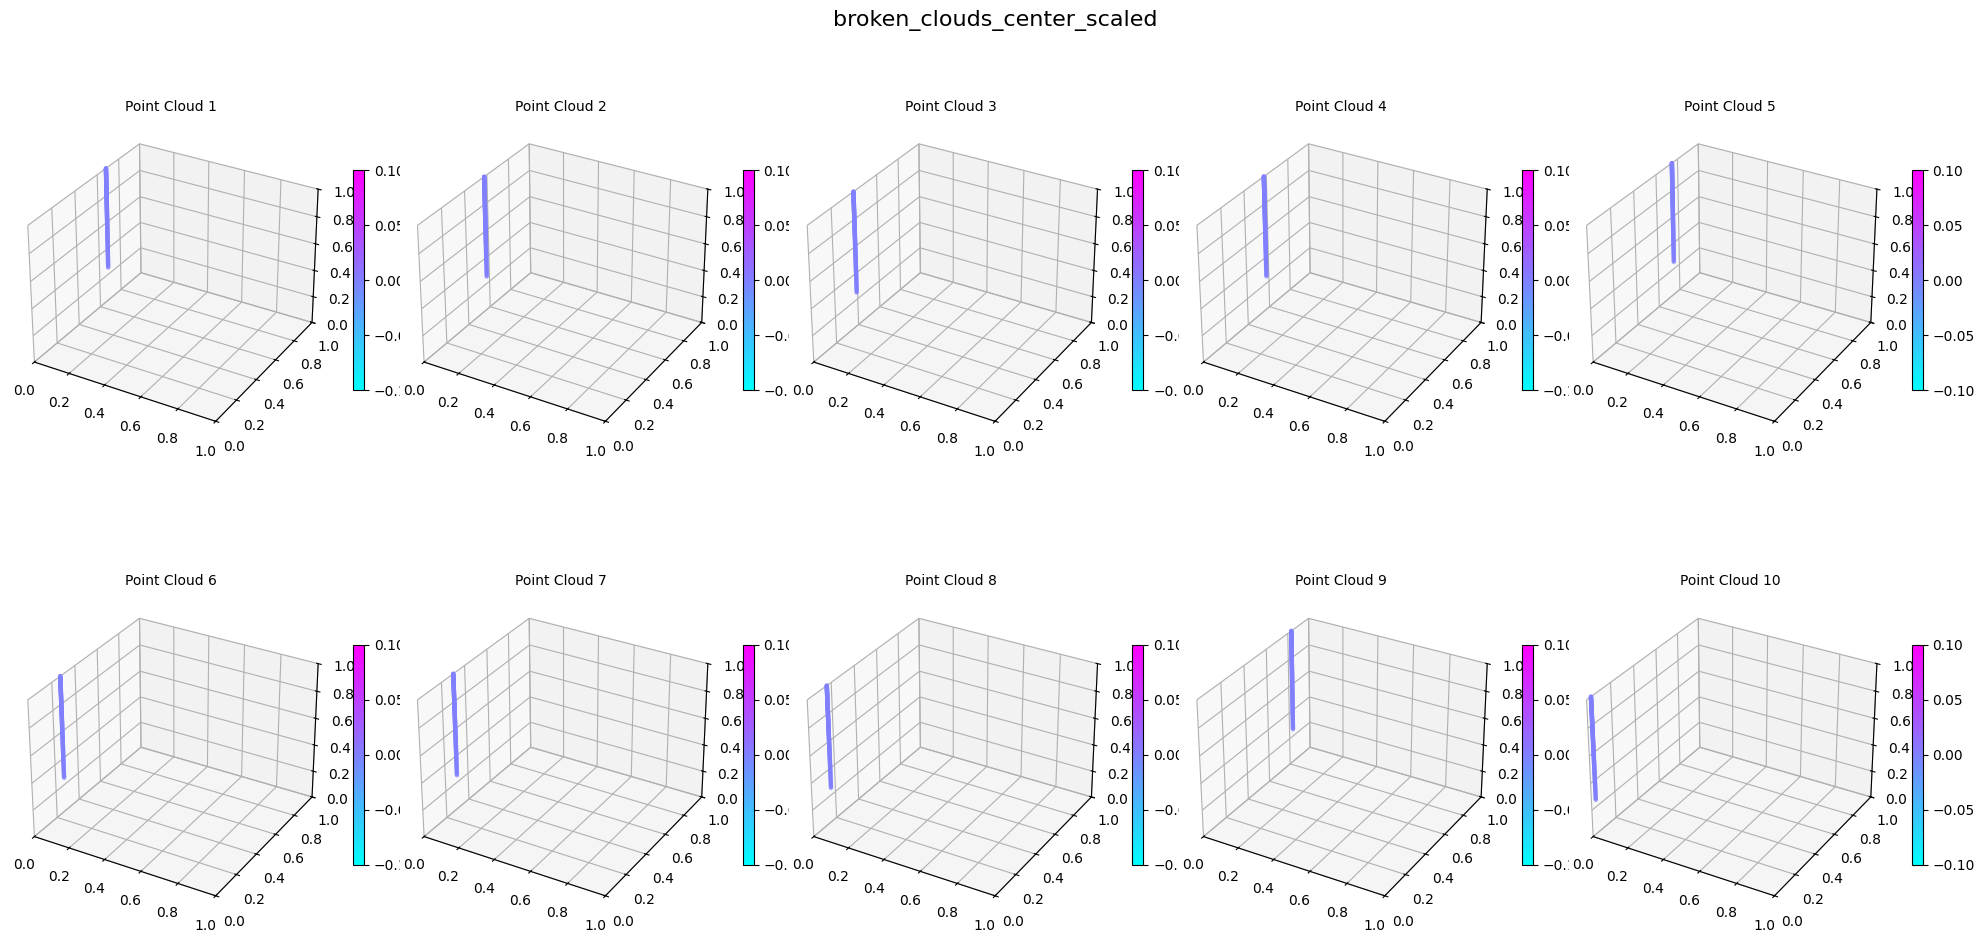

In [24]:
data_scaled = scale_data(data, RANGES)
broken_clouds_center_scaled = scale_data(broken_clouds_center, RANGES)
plot_4d_point_clouds_scaled(data_scaled[:10], "broken_clouds_center_scaled")
plot_4d_point_clouds_scaled(broken_clouds_center_scaled[:10], "broken_clouds_center_scaled")
#plot_4d_point_clouds(broken_clouds_center[:5], "broken_clouds_center")

In [58]:
np.save("line_i_center.npy", broken_clouds_center_scaled)
np.save("line_c.npy", data_scaled)
